In [2]:
from moviepy.editor import VideoFileClip
from matplotlib import pyplot as plt
from dataclasses import dataclass
import numpy as np
import cv2 as cv
import time
import os

In [3]:
@dataclass
class MatchingMonitor:
    img1: np.ndarray
    img2: np.ndarray
    img3: np.ndarray
    effective_matches: int
    available_matches: int

    def __post_init__(self):
        self.ratio: float = 1.0 * self.effective_matches / self.available_matches


In [4]:
class FeatureMatching:
    def __init__(self) -> None:
        self.sift = cv.SIFT_create()
        self.flann = self._init_falann()

    def _init_falann(self):
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        return cv.FlannBasedMatcher(index_params, search_params)

    def match(self, img1, img2, LoweRatio: float = 0.7):
        try:
            kp1, des1 = self.sift.detectAndCompute(img1, None)
            kp2, des2 = self.sift.detectAndCompute(img2, None)

            matches = self.flann.knnMatch(des1, des2, k=2)
            # store all the good matches as per Lowe's ratio test.
            good = []
            for m, n in matches:
                if m.distance < LoweRatio * n.distance:
                    good.append(m)

            MIN_MATCH_COUNT = 10
            if len(good) > MIN_MATCH_COUNT:
                src_pts = np.float32([kp1[m.queryIdx].pt
                                      for m in good]).reshape(-1, 1, 2)
                dst_pts = np.float32([kp2[m.trainIdx].pt
                                      for m in good]).reshape(-1, 1, 2)
                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
                matchesMask = mask.ravel().tolist()
                h, w = img1.shape
                pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1],
                                  [w - 1, 0]]).reshape(-1, 1, 2)
                dst = cv.perspectiveTransform(pts, M)
                img2 = cv.polylines(img2, [np.int32(dst)], True, 255, 3,
                                    cv.LINE_AA)
            else:
                print("Not enough matches are found - {}/{}".format(
                    len(good), MIN_MATCH_COUNT))
                matchesMask = None
                img3 = cv.drawMatches(img1, None, img2, None, None, None)
                return MatchingMonitor(img1,
                                       img2,
                                       img3,
                                       effective_matches=len(good),
                                       available_matches=len(matches))

            draw_params = dict(
                matchColor=(0, 255, 0),  # draw matches in green color
                singlePointColor=None,
                matchesMask=matchesMask,  # draw only inliers
                flags=2)
            img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None,
                                  **draw_params)
            # plt.imshow(img3, 'gray'), plt.show()
            # print(len(good), len(matches))
            return MatchingMonitor(img1,
                                   img2,
                                   img3,
                                   effective_matches=len(good),
                                   available_matches=len(matches))
        except:
            return MatchingMonitor(img1, img2, None, None, None)


In [5]:
video = VideoFileClip("/Users/huxiao/Documents/document/HD/同步拓展课1_2022-06-26 18_00_00-2022-06-26 20_00_00.mp4")
feature_matching = FeatureMatching()

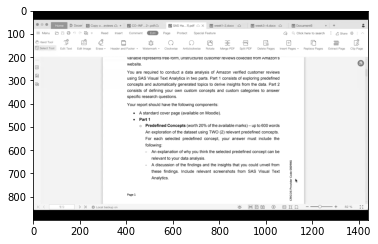

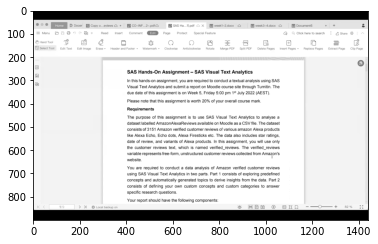

(<matplotlib.image.AxesImage at 0x7fe1ae524370>, None)

In [29]:
img1 = cv.cvtColor(video.get_frame(t=13.0), cv.COLOR_RGB2GRAY)
plt.imshow(img1, 'gray'), plt.show()
img2 = cv.cvtColor(video.get_frame(t=14.0), cv.COLOR_RGB2GRAY)
plt.imshow(img2, 'gray'), plt.show()


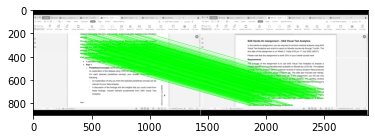

(<matplotlib.image.AxesImage at 0x7fe1ae670df0>, None)

In [30]:
e = feature_matching.match(img1, img2)
plt.imshow(e.img3), plt.show()

In [7]:
duration = [4440, 4560] # 1:14:00 - 1:16:00  -> 切出课件
duration = [0, 100]

In [8]:
matches_dict = dict()
for i in range(*duration):
    img1 = cv.cvtColor(video.get_frame(t=i), cv.COLOR_RGB2GRAY)
    img2 = cv.cvtColor(video.get_frame(t=i + 1), cv.COLOR_RGB2GRAY)
    try:
        match_monitor = feature_matching.match(img1, img2)
        matches_dict[(i, i + 1)] = match_monitor
    except:
        print("frame [{}, {}] no available features".format(i, i + 1))


frame [10, 11] no available features
Not enough matches are found - 0/10
frame [11, 12] no available features


(16, 17) -> 282/4058 0.07


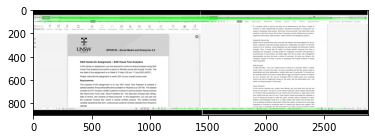

(21, 22) -> 444/4123 0.11


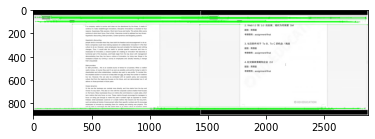

(22, 23) -> 590/1424 0.41


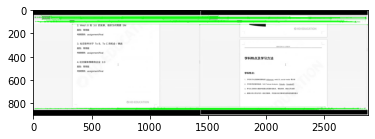

(23, 24) -> 562/1606 0.35


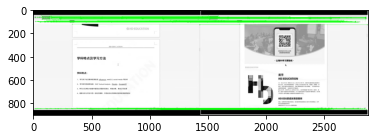

(24, 25) -> 483/2887 0.17


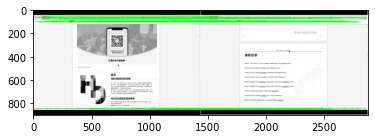

(25, 26) -> 617/1572 0.39


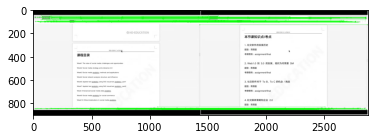

In [28]:
for i in range(*duration):
    if (i, i + 1) not in matches_dict:
        continue
    e: MatchingMonitor = matches_dict[(i, i + 1)]
    if e.ratio > 0.45:
        continue
    print("({}, {}) -> {}/{} {:.2f}".format(i, i + 1, e.effective_matches,
                                            e.available_matches, e.ratio))
    plt.imshow(e.img3), plt.show()
    time.sleep(0.5)
